In [2]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

import os
import sys
import importlib

sys.path.insert(0, "..")

import draughts
import board
import preprocessing
import engine

importlib.reload(draughts);
importlib.reload(board);
importlib.reload(preprocessing);
importlib.reload(engine);

In [3]:
import draughts

In [4]:
my_board = draughts.Board()
my_board

. o . o . o . o
o . o . o . o .
. o . o . o . o
. . . . . . . .
. . . . . . . .
O . O . O . O .
. O . O . O . O
O . O . O . O .

In [5]:
# my_board.engine.force_push(engine.Move("f6d4"))

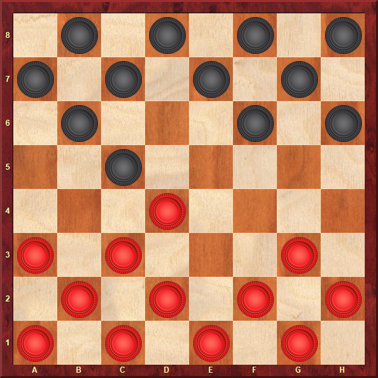

In [6]:
# my_board.push("h2g3")
my_board.push("e3d4")
my_board.push("d6c5")
my_board.show()

In [7]:
my_board.valid_moves()

(Move( d4e5 ),
 Move( a3b4 ),
 Move( c3b4 ),
 Move( g3f4 ),
 Move( g3h4 ),
 Move( d2e3 ),
 Move( f2e3 ))

In [370]:
my_board.engine._fig_count

{'.': 40, 'o': 12, 'O': 12}

In [371]:
my_board.engine.is_draw()

False

In [8]:
my_board.engine.is_finished()

<GameState.INDETERMINATE: 3>

In [9]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

tf.config.run_functions_eagerly(True)

2021-12-20 17:02:49.082408: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-20 17:02:49.082432: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
# def get_conv_net():
#     model = keras.models.Sequential()
#     model.add(layers.Conv2D(32, (2, 2), activation="relu", input_shape=(8, 8, 5)))
#     # model.add(layers.BatchNormalization())
#     model.add(layers.MaxPool2D())
#     model.add(layers.Conv2D(64, (2, 2), activation="relu"))
#     # model.add(layers.BatchNormalization())
#     model.add(layers.MaxPool2D())
#     model.add(layers.Flatten())
#     model.add(layers.Dense(128, activation="relu"))
#     model.add(layers.Dropout(0.3))
#     model.add(layers.Dense(128, activation="sigmoid"))

#     model.compile(optimizer="adam", 
#                   loss=keras.losses.MeanSquaredError(), 
#                   metrics=["accuracy"])
    
#     return model

def get_conv_net():
    model = keras.models.Sequential()
    model.add(layers.Conv2D(128, (2, 2), activation="relu", input_shape=(8, 8, 5)))
    # model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(128, (2, 2), activation="relu"))
    # model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D())
#     model.add(layers.Conv2D(128, (2, 2), activation="relu"))
    # model.add(layers.BatchNormalization())
#     model.add(layers.MaxPool2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation="sigmoid"))

    model.compile(optimizer="adam", 
                  loss=keras.losses.MeanSquaredError(), 
                  metrics=["accuracy"])
    
    return model

In [11]:
white_model = get_conv_net()
black_model = get_conv_net()

2021-12-20 17:02:53.073268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-20 17:02:53.073294: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-20 17:02:53.073313: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tigran-System-Product-Name): /proc/driver/nvidia/version does not exist


In [12]:
inp = preprocessing.board_layout_to_network_input(my_board.engine.layout)
inp.shape

(8, 8, 5)

In [13]:
move = engine.Move("a1a2")
move.from_pos

'a1'

In [14]:
def get_network_move(output):
    from_index = output[:64].argmax()
    to_index = output[64:].argmax()
    return engine.Move.from_indices(from_index, to_index)

num_dict = {l : i+1 for i, l in enumerate("abcdefgh")}

def cell_dist(cell1, cell2):
    p1 = np.array([num_dict[cell1[0]], int(cell1[1])])
    p2 = np.array([num_dict[cell2[0]], int(cell2[1])])
    return np.linalg.norm(p1 - p2)


def find_closest_move(move, valid_moves):
    distance = np.inf
    best_moves = []
    for m in valid_moves:
        dist = cell_dist(move.from_pos, m.from_pos)
        if dist < distance:
            best_moves.append(m)
            distance = dist
            
    closest_move = None
    distance = np.inf
            
    for m in best_moves:
        dist = cell_dist(move.to_pos, m.to_pos)
        if dist < distance:
            closest_move = m
            distance = dist
            
    return closest_move

In [707]:
output = model.predict(np.array([inp]))

In [445]:
get_network_move(output[0])

Move( g5c5 )

In [17]:
my_board = draughts.Board()

white_won = 0
black_won = 0
iter_count = 0

In [18]:
def cost_function(w, b):
    return abs(w - b)

In [94]:
def train():
    
    global my_board
    global white_won
    global black_won
    global iter_count
    
    for i in range(20000):
        iter_count += 1
        if iter_count % 200 == 0:
            white_model.save_weights("new_w_weights.h5")
            black_model.save_weights("new_b_weights.h5")
            
        white_train_data = []
        white_test_data = []

        black_train_data = []
        black_test_data = []

        while my_board.engine.is_finished() == engine.GameState.INDETERMINATE or my_board.engine.is_draw():
            b_valid_moves = my_board.valid_moves()
            
            if len(b_valid_moves) == 0: break
                
            closest_move = None
            inp = preprocessing.board_layout_to_network_input(my_board.engine.layout)
            
            if np.random.randint(4) != 0:
                if my_board.engine.turn:
                    net_move = get_network_move(white_model.predict(np.array([inp]))[0])
                    closest_move = find_closest_move(net_move, b_valid_moves)
                elif not my_board.engine.turn:
                    net_move = get_network_move(black_model.predict(np.array([inp]))[0])
                    closest_move = find_closest_move(net_move, b_valid_moves)
            else:
                closest_move = np.random.choice(b_valid_moves)
                
            my_board.push_move(closest_move)

            from_in_base = np.zeros(64)
            from_in_base[closest_move.from_index] = 1

            to_in_base = np.zeros(64)
            to_in_base[closest_move.to_index] = 1

            move_out = np.array([*from_in_base, *to_in_base])

            if my_board.engine.turn:
                white_train_data.append(inp)
                white_test_data.append(move_out)
            elif not my_board.engine.turn:
                black_train_data.append(inp)
                black_test_data.append(move_out)

        if my_board.engine.is_finished() == engine.GameState.WHITE_WON:
            print("White won")
            white_won += 1
            white_model.fit(np.array(white_train_data), np.array(white_test_data), epochs=100, batch_size=32)
        if my_board.engine.is_finished() == engine.GameState.BLACK_WON:
            print("Black won")
            black_won += 1
            black_model.fit(np.array(black_train_data), np.array(black_test_data), epochs=100, batch_size=32)

        my_board.engine.reset()
        print("Cost function ~ ", cost_function(white_won, black_won))

In [ ]:
# def train_function():
#     try:
#         if iter_count != 20000:
#             train()
#     except:
#         train_function()

# train_function()
# import logging
tf.autograph.set_verbosity(0, False)
train()

White won
Epoch 1/100
2/2 [==============================] - 0s 20ms/step - loss: 0.0094 - accuracy: 0.5152
Epoch 2/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0096 - accuracy: 0.5758
Epoch 3/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0096 - accuracy: 0.4848
Epoch 4/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0076 - accuracy: 0.5455
Epoch 5/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0080 - accuracy: 0.6364
Epoch 6/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0075 - accuracy: 0.4848
Epoch 7/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0087 - accuracy: 0.4848
Epoch 8/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0089 - accuracy: 0.4848
Epoch 9/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0081 - accuracy: 0.4848
Epoch 10/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0078 - accuracy: 0.5758
Epoch 11/

2/2 [==============================] - 0s 17ms/step - loss: 0.0065 - accuracy: 0.6061
Epoch 84/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0057 - accuracy: 0.6061
Epoch 85/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0059 - accuracy: 0.4848
Epoch 86/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0060 - accuracy: 0.5152
Epoch 87/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0062 - accuracy: 0.6061
Epoch 88/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0065 - accuracy: 0.5455
Epoch 89/100
2/2 [==============================] - 0s 23ms/step - loss: 0.0062 - accuracy: 0.5758
Epoch 90/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0060 - accuracy: 0.6061
Epoch 91/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0063 - accuracy: 0.5455
Epoch 92/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0063 - accuracy: 0.5758
Epoch 93/100
2/2 [=====

In [102]:
iter_count

13897

In [89]:
white_model.save_weights("new_w_weights.h5")
black_model.save_weights("new_b_weights.h5")

In [100]:
my_board.engine.reset()

In [46]:
white_won, black_won

(4065, 4060)

In [545]:
my_board.engine._fig_count

{'.': 40, 'o': 12, 'O': 12}

In [560]:
my_board.engine.is_finished()

<GameState.INDETERMINATE: 3>

In [527]:
my_board.valid_moves()

()

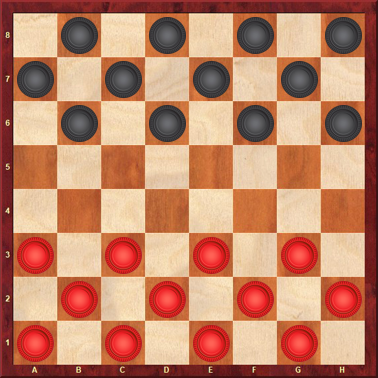

In [546]:
my_board.show()

In [308]:
np.random.choice([1, 2, 3])

2

In [685]:
new_board = draughts.Board()

def play(move):
    new_board.push(move)
    output_vec = white_model.predict(np.array([preprocessing.board_layout_to_network_input(new_board.engine.layout)]))
#     print(output_vec)
    net_move = get_network_move(output_vec[0])
    closest_move = find_closest_move(net_move, new_board.valid_moves())
    print("Network move", net_move)
    print(closest_move)
    new_board.push_move(closest_move)
    display(new_board.show())

Network move Move( c5e3 )
Move( c5a3 )


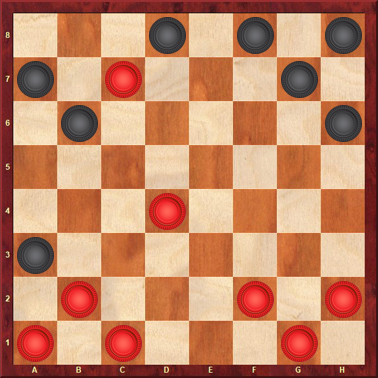

In [696]:
play("d2b4")

In [675]:
# new_board.show()